In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import torchvision.models
import torchvision.transforms as transforms
import torch
from torch.utils.data import Dataset
import torch.nn as nn
from tqdm.notebook import tqdm

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [2]:
import os
for dirname, _, filenames in os.walk('./traffic-signs-preprocessed'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

print(os.listdir('./traffic-signs-preprocessed'))

./traffic-signs-preprocessed/mean_image_rgb.pickle
./traffic-signs-preprocessed/data1.pickle
./traffic-signs-preprocessed/train.pickle
./traffic-signs-preprocessed/datasets_preparing.py
./traffic-signs-preprocessed/data2.pickle
./traffic-signs-preprocessed/data4.pickle
./traffic-signs-preprocessed/valid.pickle
./traffic-signs-preprocessed/data7.pickle
./traffic-signs-preprocessed/std_rgb.pickle
./traffic-signs-preprocessed/data3.pickle
./traffic-signs-preprocessed/label_names.csv
./traffic-signs-preprocessed/mean_image_gray.pickle
./traffic-signs-preprocessed/test.pickle
./traffic-signs-preprocessed/data5.pickle
./traffic-signs-preprocessed/labels.pickle
./traffic-signs-preprocessed/data8.pickle
./traffic-signs-preprocessed/data6.pickle
./traffic-signs-preprocessed/std_gray.pickle
./traffic-signs-preprocessed/data0.pickle
['mean_image_rgb.pickle', 'data1.pickle', 'train.pickle', 'datasets_preparing.py', 'data2.pickle', 'data4.pickle', 'valid.pickle', 'data7.pickle', 'std_rgb.pickle', '

In [3]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

In [4]:

IDX = 1

with open(f'./traffic-signs-preprocessed/data{IDX}.pickle', 'rb') as f:
    data = pickle.load(f, encoding='latin1')  # dictionary type

    
#for i in tqdm(range(2, 7)):
 #   with open(f'./traffic-signs-preprocessed/data{i}.pickle', 'rb') as f:
  #      data1 = pickle.load(f, encoding='latin1')  # dictionary type
   # for key in what:
    #    print(data[key].shape,data1[key].shape, )
     #   data[key] = np.concatenate((data[key], data1[key]), axis=0)
    #print(data['x_train'].shape)

In [5]:
data['y_train'] = to_categorical(data['y_train'], num_classes=43)
data['y_validation'] = to_categorical(data['y_validation'], num_classes=43)

# Making channels come at the end
data['x_train'] = data['x_train']#.transpose(0, 2, 3, 1)
data['x_validation'] = data['x_validation']#.transpose(0, 2, 3, 1)
data['x_test'] = data['x_test']#.transpose(0, 2, 3, 1)

# Showing loaded data from file
for i, j in data.items():
    if i == 'labels':
        print(i + ':', len(j))
    else: 
        print(i + ':', j.shape)
print(type(data))

x_train: (86989, 3, 32, 32)
y_test: (12630,)
x_test: (12630, 3, 32, 32)
x_validation: (4410, 3, 32, 32)
labels: 43
y_train: (86989, 43)
y_validation: (4410, 43)
<class 'dict'>


(81, 32, 32, 3)


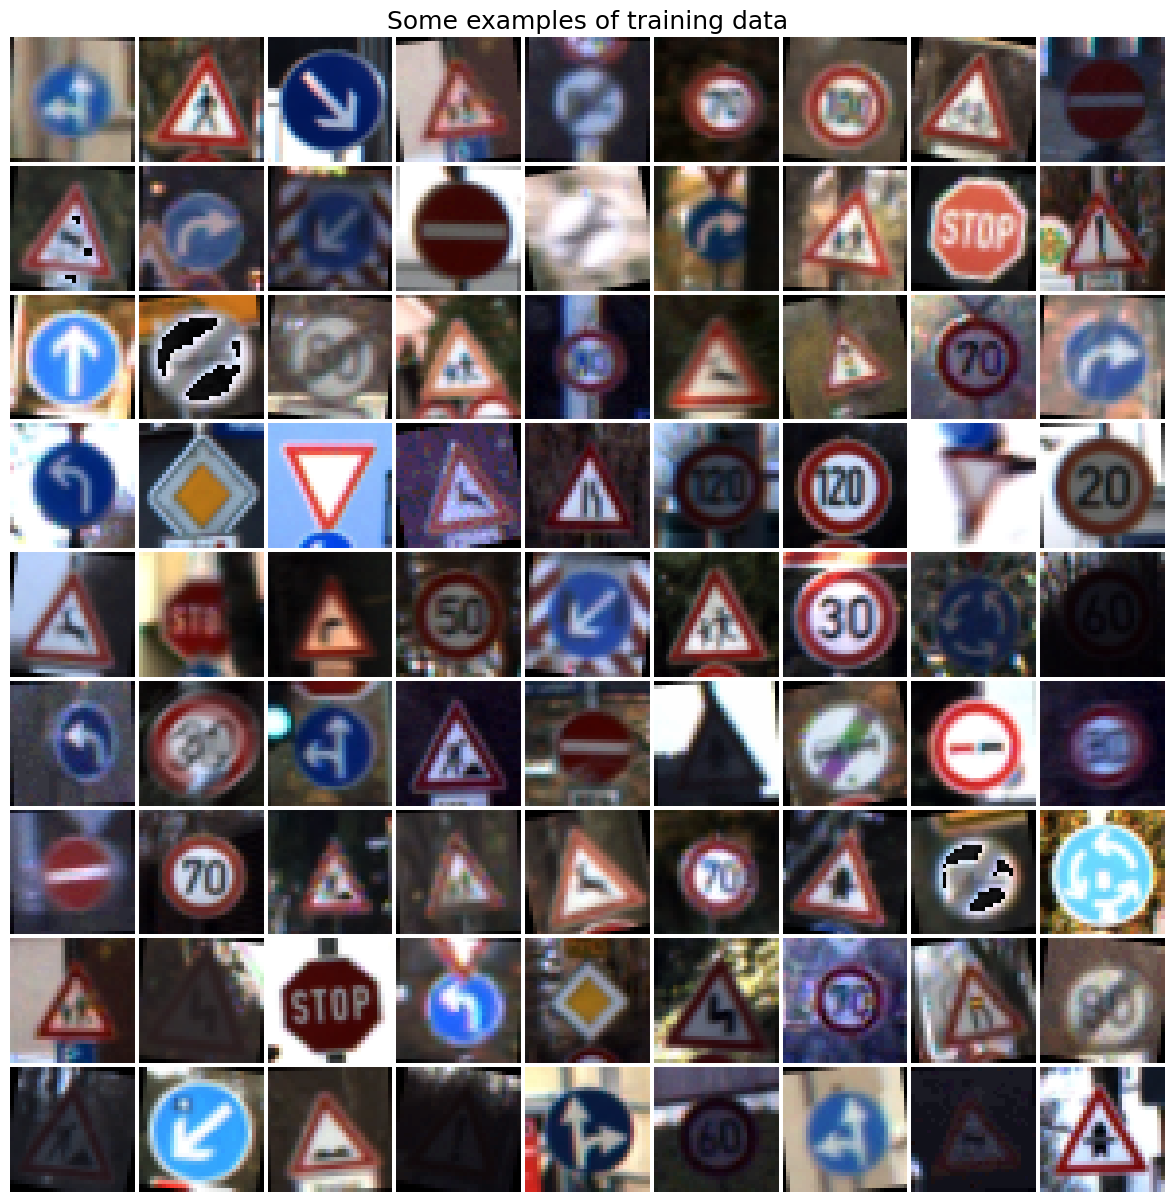

In [6]:
%matplotlib inline

# Preparing function for ploting set of examples
# As input it will take 4D tensor and convert it to the grid
# Values will be scaled to the range [0, 255]
def convert_to_grid(x_input):
    N, H, W, C = x_input.shape
    grid_size = int(np.ceil(np.sqrt(N)))
    grid_height = H * grid_size + 1 * (grid_size - 1)
    grid_width = W * grid_size + 1 * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C)) + 255
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = x_input[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = 255.0 * (img - low) / (high - low)
                next_idx += 1
            x0 += W + 1
            x1 += W + 1
        y0 += H + 1
        y1 += H + 1

    return grid


# Visualizing some examples of training data
examples = data['x_train'][:81, :, :, :].transpose(0, 2, 3, 1)
print(examples.shape)  # (81, 32, 32, 3)

# Plotting some examples
fig = plt.figure()
grid = convert_to_grid(examples)
plt.imshow(grid.astype('uint8'), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(15, 15)
plt.title('Some examples of training data', fontsize=18)

# Showing the plot
plt.show()

# Saving the plot
fig.savefig('training_examples.png')
plt.close()

In [7]:
model = torchvision.models.resnet34(weights = torchvision.models.ResNet34_Weights.IMAGENET1K_V1)
model.fc = nn.Sequential(
    model.fc,
    nn.ReLU(),
    nn.Linear(1000, 512, True),
    nn.ReLU(),
    nn.Linear(512, 43, True),
    nn.Softmax(dim=1)
)
            
model = model.to(device)

In [8]:
transform = transforms.Compose(
    [#transforms.ToTensor(),
     #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
     transforms.Resize((224, 224), antialias=True)
    
    ])


In [9]:
batch_size = 64
num_workers = 20
shuffle=True
NUM_EPOCHS = 5

In [10]:
class MyDataset(Dataset):
    def __init__(self, x, y):
        self.data = x
        self.target = y
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        return {'data': x, 'target': y}
    
    def __len__(self):
        return len(self.data)
    
trainset = MyDataset(data['x_train'], data['y_train'])
valiset = MyDataset(data['x_validation'], data['y_validation'])

In [11]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=shuffle, num_workers=num_workers)
valiloader = torch.utils.data.DataLoader(valiset, batch_size=batch_size,
                                          shuffle=shuffle, num_workers=num_workers)

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 3e-4 )



In [13]:
def multi_acc(y_pred, y_test):
    #y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    indices = torch.argmax(y_pred, dim = 1) 
    indices2 = torch.argmax(y_test, dim = 1) 
    #print(y_test)
    #print(y_pred.shape, y_test.shape)
    correct_pred = (indices == indices2).float().cpu()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [14]:
loss_list = []
acc_list = []

vali_loss_list = []
acc_vali_list = []

for epoch in tqdm(range(NUM_EPOCHS), position=0):
    running_loss = 0.0
    model.train()
    
    progress = tqdm(enumerate(trainloader, 0), position = 1, desc = "Loss:", total=len(trainloader))
    
    for i, data_ in progress :
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data_['data'], data_['target']
        #inputs = inputs.view(inputs.shape[0],inputs.shape[3], inputs.shape[1], inputs.shape[2]).to(device)
        inputs = transform(inputs).to(device)
        labels = labels.to(device, dtype=torch.float32)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        acc_list += [multi_acc(outputs, labels)]
        # print statistics
        running_loss += loss.item()
        loss_list.append(loss.item())
        #if i % 2000 == 1999:    # print every 2000 mini-batches
         #   print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
          #  running_loss = 0.0
        progress.set_description("Loss: {:.4f}".format(running_loss/(i+1)))
    #validation
    model.eval()
    
    progress = tqdm(enumerate(valiloader, 0), position = 2, desc = "Vali Loss:", total=len(valiloader))
    running_vali_loss = 0.0
    for i, data_ in progress:
        inputs, labels = data_['data'], data_['target']
        #inputs = inputs.view(inputs.shape[0],inputs.shape[3], inputs.shape[1], inputs.shape[2]).to(device)
        inputs = transform(inputs)
        inputs = inputs.to(device)
        labels = labels.to(device, dtype=torch.float32)
        
        outputs = model(inputs)
        val_loss = criterion(outputs, labels)
        
        vali_loss_list += [val_loss.item()]
        acc_vali_list += [multi_acc(outputs, labels)]
        running_vali_loss+= val_loss.item()
        progress.set_description("Vali Loss: {:.4f}".format(running_vali_loss/(i+1)))

    

  0%|          | 0/5 [00:00<?, ?it/s]

Loss::   0%|          | 0/1360 [00:00<?, ?it/s]

Vali Loss::   0%|          | 0/69 [00:00<?, ?it/s]

Loss::   0%|          | 0/1360 [00:00<?, ?it/s]

Vali Loss::   0%|          | 0/69 [00:00<?, ?it/s]

Loss::   0%|          | 0/1360 [00:00<?, ?it/s]

Vali Loss::   0%|          | 0/69 [00:00<?, ?it/s]

Loss::   0%|          | 0/1360 [00:00<?, ?it/s]

Vali Loss::   0%|          | 0/69 [00:00<?, ?it/s]

Loss::   0%|          | 0/1360 [00:00<?, ?it/s]

Vali Loss::   0%|          | 0/69 [00:00<?, ?it/s]

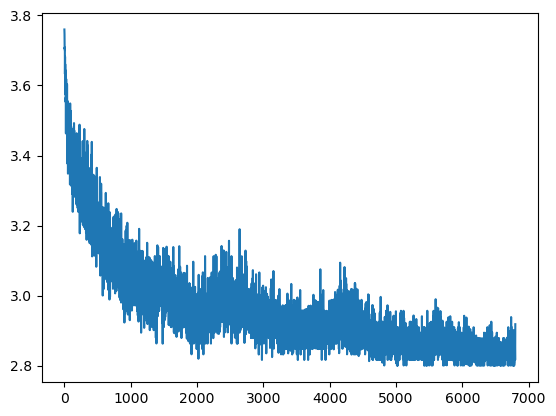

In [15]:
plt.plot(loss_list)

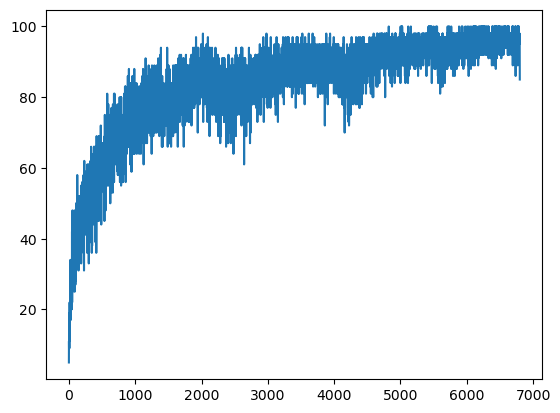

In [16]:
plt.plot(acc_list)

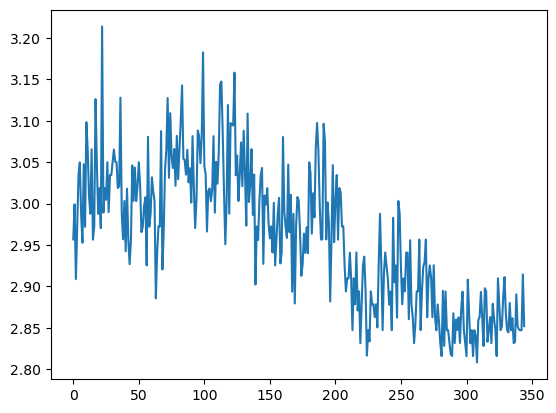

In [17]:
#vali_loss_list = [v.detach().cpu() for v in vali_loss_list]
plt.plot(vali_loss_list)


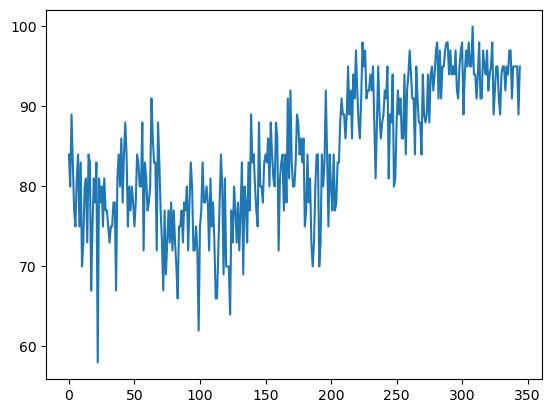

In [18]:
plt.plot(acc_vali_list)

In [20]:
torch.save(model.state_dict(), "./tl_classification.pth")